In [2]:
##if using django 3.0 set:

#import os
#os.environ.setdefault("DJANGO_ALLOW_ASYNC_UNSAFE", "true")

##check:
#%env

# Example of model fit, predict* and conversion to raster using API of antares3

*Prediction is pixel wise.

**Will use an already ingested and processed Sentinel2 data via antares3**

## Some imports

In [5]:
import sys
import os
import json

import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import dill

In [6]:
sys.__stdout__ = sys.stdout 

In [7]:
from datacube.api import GridWorkflow

from madmex.util.db import get_cmap_from_scheme
from madmex.models import Tag
from madmex.overlay.extractions import zonal_stats_xarray
from madmex.io.vector_db import VectorDb
from madmex.wrappers import gwf_query
from madmex.modeling.supervised.xgb import Model
from madmex.models import Tag
from madmex.overlay.extractions import zonal_stats_xarray
from madmex.util import randomword

In [8]:
sys.stdout = sys.__stdout__

In [9]:
path = "/LUSTRE/MADMEX/tasks/2020/7_forests_maps_julian"

## Fit model

**Next will use an already product registered in the datacube DB. Query will also use region and date.**

In [10]:
name_of_product = 'recipe_mex_s2_20m_resampled_to_10m_2018_2019' #an already processed Sentinel2 data
region = 'mexico_Quintana_Roo'
begin = '2018-01-01'
end = '2019-12-31'

gwf_kwargs = {'region': region, 
              'product': name_of_product, 
              'begin': begin, 
              'end':end}

**Query**

In [11]:
iterable = gwf_query(**gwf_kwargs)

**Sort list of results of query**

In [12]:
list_iter_20m = list(iterable)

In [13]:
list_iter_20m_sorted = sorted(list_iter_20m, key = lambda x: (x[0][0], x[0][1]))

**Datacube tiles indexes:**

In [14]:
[index[0] for index in list_iter_20m_sorted]

[(56, -31),
 (57, -34),
 (57, -33),
 (57, -32),
 (57, -31),
 (57, -30),
 (58, -35),
 (58, -34),
 (58, -33),
 (58, -32),
 (58, -31),
 (58, -30),
 (58, -29),
 (59, -33),
 (59, -32),
 (59, -31),
 (59, -30),
 (59, -29),
 (59, -28),
 (60, -34),
 (60, -33),
 (60, -32),
 (60, -31),
 (60, -30),
 (60, -29),
 (60, -28),
 (60, -27),
 (60, -26),
 (61, -33),
 (61, -32),
 (61, -29),
 (61, -28),
 (61, -27),
 (61, -26),
 (62, -28)]

**Select datacube tile index: (59, -31)**

In [15]:
tile = [index for index in list_iter_20m_sorted if index[0] == (59, -31)][0]

In [16]:
tile

((59, -31),
 Tile<sources=<xarray.DataArray (time: 1)>
 array([(Dataset <id=86104349-189e-5c2b-9636-f4139a700f01 type=recipe_mex_s2_20m_resampled_to_10m_2018_2019 location=file://shared_volume/datacube/datacube_ingest/recipes/recipe_mex_s2_20m_resampled_to_10m_2018_2019/s2_20m_001_59_-31_2018-12-31.nc>,)],
       dtype=object)
 Coordinates:
   * time     (time) datetime64[ns] 2018-12-31T12:00:00,
 	geobox=GeoBox(5002, 5002, Affine(10.0, 0.0, 3928340.0,
        0.0, -10.0, 926120.0), PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS84",6378137,6556752.3141]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0]])>)

**Load via Grid Workflow API**

In [17]:
ds = GridWorkflow.load(tile[1])

**Print some info...**

In [18]:
ds

<xarray.Dataset>
Dimensions:     (time: 1, x: 5002, y: 5002)
Coordinates:
  * time        (time) datetime64[ns] 2018-12-31T12:00:00
  * y           (y) float64 9.261e+05 9.261e+05 ... 8.761e+05 8.761e+05
  * x           (x) float64 3.928e+06 3.928e+06 ... 3.978e+06 3.978e+06
Data variables:
    blue_mean   (time, y, x) int16 456 456 453 453 452 ... 589 555 555 566 566
    green_mean  (time, y, x) int16 606 606 622 622 634 ... 794 741 741 745 745
    red_mean    (time, y, x) int16 431 431 452 452 464 ... 573 520 520 512 512
    re1_mean    (time, y, x) int16 904 904 950 950 970 ... 1114 1114 1116 1116
    re2_mean    (time, y, x) int16 2168 2168 2267 2267 ... 2675 2675 2693 2693
    re3_mean    (time, y, x) int16 2685 2685 2816 2816 ... 3293 3293 3301 3301
    nir_mean    (time, y, x) int16 3000 3000 3137 3137 ... 3663 3663 3672 3672
    swir1_mean  (time, y, x) int16 1604 1604 1656 1656 ... 1844 1844 1852 1852
    swir2_mean  (time, y, x) int16 798 798 840 840 837 ... 956 923 923 923 923
    ndvi_mean   (time, y, x) int16 7628 7628 7667 7667 ... 7673 7673 7646 7646
    ndmi_mean   (time, y, x) int16 3095 3095 3199 3199 ... 3358 3358 3338 3338
    ndvi_max    (time, y, x) int16 9047 9047 8985 8985 ... 9488 9488 9415 9415
    ndvi_min    (time, y, x) int16 2028 2028 2134 2134 ... 2631 2631 2728 2728
    ndmi_max    (time, y, x) int16 4719 4719 4647 4647 ... 4392 4392 4439 4439
    ndmi_min    (time, y, x) int16 1731 1731 2055 2055 1602 ... 755 755 638 638
    elevation   (time, y, x) int16 26 29 29 29 29 29 29 ... 13 12 12 12 12 12 12
    slope       (time, y, x) float32 0.55771154 0.58900684 ... 0.43751022
    aspect      (time, y, x) float32 326.30994 23.198593 ... 315.0 315.0
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...

In [14]:
ds

<xarray.Dataset>
Dimensions:     (time: 1, x: 5002, y: 5002)
Coordinates:
  * time        (time) datetime64[ns] 2018-12-31T12:00:00
  * y           (y) float64 9.261e+05 9.261e+05 ... 8.761e+05 8.761e+05
  * x           (x) float64 3.928e+06 3.928e+06 ... 3.978e+06 3.978e+06
Data variables:
    blue_mean   (time, y, x) int16 456 456 453 453 452 ... 589 555 555 566 566
    green_mean  (time, y, x) int16 606 606 622 622 634 ... 794 741 741 745 745
    red_mean    (time, y, x) int16 431 431 452 452 464 ... 573 520 520 512 512
    re1_mean    (time, y, x) int16 904 904 950 950 970 ... 1114 1114 1116 1116
    re2_mean    (time, y, x) int16 2168 2168 2267 2267 ... 2675 2675 2693 2693
    re3_mean    (time, y, x) int16 2685 2685 2816 2816 ... 3293 3293 3301 3301
    nir_mean    (time, y, x) int16 3000 3000 3137 3137 ... 3663 3663 3672 3672
    swir1_mean  (time, y, x) int16 1604 1604 1656 1656 ... 1844 1844 1852 1852
    swir2_mean  (time, y, x) int16 798 798 840 840 837 ... 956 923 923 923 923
    ndvi_mean   (time, y, x) int16 7628 7628 7667 7667 ... 7673 7673 7646 7646
    ndmi_mean   (time, y, x) int16 3095 3095 3199 3199 ... 3358 3358 3338 3338
    ndvi_max    (time, y, x) int16 9047 9047 8985 8985 ... 9488 9488 9415 9415
    ndvi_min    (time, y, x) int16 2028 2028 2134 2134 ... 2631 2631 2728 2728
    ndmi_max    (time, y, x) int16 4719 4719 4647 4647 ... 4392 4392 4439 4439
    ndmi_min    (time, y, x) int16 1731 1731 2055 2055 1602 ... 755 755 638 638
    elevation   (time, y, x) int16 26 29 29 29 29 29 29 ... 13 12 12 12 12 12 12
    slope       (time, y, x) float32 0.55771154 0.58900684 ... 0.43751022
    aspect      (time, y, x) float32 326.30994 23.198593 ... 315.0 315.0
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...

**Visualize one band... e.g. `ndvi_mean`...**

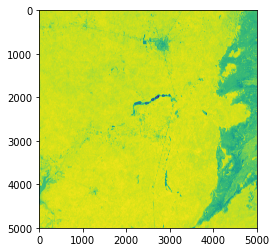

In [19]:
plt.imshow(ds.ndvi_mean[0,:,:])
plt.show()

**Load already registered training data in antares3 db...**

In [16]:
training_data = "points_quintana_roo_s2_2018_madmex_17_classes"

In [17]:
loader = VectorDb()
fc_train_0 = loader.load_training_from_dataset(dataset=ds,
                                               training_set=training_data, 
                                               sample=1)

In [18]:
# Evaluate the generator (safe to do here since the data is not huge)
fc_train_0 = list(fc_train_0)

In [19]:
len(fc_train_0)

9787

In [20]:
fc_train_0[0]

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [3930908.014362283, 872235.9249802266]},
 'properties': {'class': 41}}

**Assign code level to this training data according to next scheme..**

In [21]:
scheme = "madmex_17"

In [22]:
qs = Tag.objects.filter(scheme=scheme)
tag_mapping = {x.id:x.numeric_code for x in qs}
tag_id_list = [x['properties']['class'] for x in fc_train_0]


In [23]:
fc_train = [{'geometry': x[0]['geometry'],
             'properties': {'code': tag_mapping[x[1]]},
             'type': 'feature'} for x in zip(fc_train_0, tag_id_list)]

In [24]:
fc_train[0]

{'geometry': {'type': 'Point',
  'coordinates': [3930908.014362283, 872235.9249802266]},
 'properties': {'code': 5},
 'type': 'feature'}

**Extract some zonal statistics using dataset and feature collection of training data...**

In [25]:
X_train, y_train = zonal_stats_xarray(ds, 
                                      fc_train, 
                                      "code")

In [26]:
X_train

array([[2.78000000e+02, 4.42000000e+02, 2.67000000e+02, ...,
        3.20000000e+01, 3.94367814e-01, 3.48690063e+02],
       [7.18000000e+02, 8.39000000e+02, 6.44000000e+02, ...,
        2.90000000e+01, 7.73384154e-01, 3.06869904e+02],
       [6.51000000e+02, 8.16000000e+02, 6.56000000e+02, ...,
        2.70000000e+01, 4.89148915e-01, 3.41565063e+02],
       ...,
       [6.86000000e+02, 8.97000000e+02, 7.03000000e+02, ...,
        3.00000000e+00, 2.10301518e+00, 1.62897278e+02],
       [8.28000000e+02, 1.02700000e+03, 8.67000000e+02, ...,
        5.00000000e+00, 5.57711542e-01, 3.26309937e+02],
       [6.25000000e+02, 7.87000000e+02, 6.76000000e+02, ...,
        7.00000000e+00, 3.09369445e-01, 0.00000000e+00]])

In [27]:
X_train.shape

(8203, 18)

In [28]:
y_train

array([ 5,  5,  5, ...,  4, 10,  5])

**Model fit: xgboost..**

In [29]:
xgb_model = Model()

In [30]:
xgb_model.fit(X_train, y_train)

**Write model to filesystem (just to load it if this notebook crashes or kernel is reloaded in the future...) ...**

In [31]:
path

'/LUSTRE/MADMEX/tasks/2020/7_forests_maps_julian'

In [32]:
random_word = randomword(5)

In [33]:
name_model = 'model_example' + '_%d_%d' %(tile[0][0],tile[0][1])
filename_model = '%s_%s.pkl' % (name_model, random_word)
filepath_model = os.path.join(path, filename_model)

In [34]:
filepath_model

'/LUSTRE/MADMEX/tasks/2020/7_forests_maps_julian/model_example_59_-31_owhwp.pkl'

In [35]:
with open(filepath_model, 'wb') as dst:
    dill.dump(xgb_model, dst)

## Predict pixel wise... based on: [predict_pixel_tile](https://github.com/CONABIO/antares3/blob/develop/madmex/wrappers.py#L50)

In [36]:
arr_3d = ds.to_array().squeeze().values #squeeze to remove time dimension 
                                        #because has length 1

In [37]:
arr_3d.shape

(18, 5002, 5002)

In [38]:
arr_3d

array([[[4.5600000e+02, 4.5600000e+02, 4.5300000e+02, ...,
         7.1800000e+02, 7.0000000e+02, 7.0000000e+02],
        [4.5600000e+02, 4.5600000e+02, 4.5300000e+02, ...,
         7.1800000e+02, 7.0000000e+02, 7.0000000e+02],
        [4.4200000e+02, 4.4200000e+02, 4.6100000e+02, ...,
         7.5200000e+02, 6.7400000e+02, 6.7400000e+02],
        ...,
        [5.1500000e+02, 5.1500000e+02, 4.0400000e+02, ...,
         5.2100000e+02, 5.7200000e+02, 5.7200000e+02],
        [5.7500000e+02, 5.7500000e+02, 5.9600000e+02, ...,
         5.5500000e+02, 5.6600000e+02, 5.6600000e+02],
        [5.7500000e+02, 5.7500000e+02, 5.9600000e+02, ...,
         5.5500000e+02, 5.6600000e+02, 5.6600000e+02]],

       [[6.0600000e+02, 6.0600000e+02, 6.2200000e+02, ...,
         8.8900000e+02, 9.3000000e+02, 9.3000000e+02],
        [6.0600000e+02, 6.0600000e+02, 6.2200000e+02, ...,
         8.8900000e+02, 9.3000000e+02, 9.3000000e+02],
        [5.9200000e+02, 5.9200000e+02, 6.4500000e+02, ...,
         9.740

**Next lines to transform array 3d to array 2d in a format as:**

**observations x variables, being observations the rows (pixels) and columns the variables already computed such as `ndvi_mean`**

In [39]:
arr_3d = np.moveaxis(arr_3d, 0, 2)

In [40]:
shape_2d = (arr_3d.shape[0] * arr_3d.shape[1], arr_3d.shape[2])

In [41]:
shape_2d

(25020004, 18)

In [42]:
arr_2d = arr_3d.reshape(shape_2d)

**Predict...**

In [43]:
predicted_array = xgb_model.predict(arr_2d)

In [44]:
predicted_array

array([5, 5, 5, ..., 5, 5, 5])

## Write raster to filesystem

**Reshape back to 2D**

In [45]:
predicted_array = predicted_array.reshape((arr_3d.shape[0], arr_3d.shape[1]))

In [46]:
predicted_array

array([[ 5,  5,  5, ..., 10, 10, 10],
       [ 5,  5,  5, ..., 10, 10, 10],
       [ 5,  5,  5, ..., 10,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5]])

**Type of values in `predicted_array` needs to be `uint8` so color map can be written with rasterio**

In [47]:
predicted_array = predicted_array.astype('uint8')

In [48]:
predicted_array.dtype

dtype('uint8')

In [49]:
predicted_array

array([[ 5,  5,  5, ..., 10, 10, 10],
       [ 5,  5,  5, ..., 10, 10, 10],
       [ 5,  5,  5, ..., 10,  4,  4],
       ...,
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5]], dtype=uint8)

**Write array to geotiff in filesystem**

In [50]:
rasterio_meta = {'width': predicted_array.shape[1],
                 'height': predicted_array.shape[0],
                 'transform': ds.affine,
                 'crs': ds.crs.crs_str,
                 'count': 1,
                 'dtype': 'uint8',
                 'compress': 'lzw',
                 'driver': 'GTiff',
                 'nodata': 0}

In [51]:
name_predict = "predict_example" + "_%d_%d" %(tile[0][0],tile[0][1])
filename_predict = "%s_%s.tif" % (name_predict, random_word)
filepath_predict = os.path.join(path, filename_predict)

In [52]:
filepath_predict

'/LUSTRE/MADMEX/tasks/2020/7_forests_maps_julian/predict_example_59_-31_owhwp.tif'

**Add color map to file that will be written in filesystem**

In [53]:
scheme

'madmex_17'

In [54]:
cmap = get_cmap_from_scheme(scheme)

In [55]:
cmap

{4: (85, 170, 255, 255),
 5: (255, 0, 127, 255),
 6: (255, 85, 255, 255),
 10: (170, 255, 255, 255),
 11: (162, 236, 177, 255),
 13: (233, 233, 175, 255),
 14: (250, 255, 152, 255),
 15: (77, 16, 9, 255),
 16: (199, 200, 188, 255),
 17: (0, 0, 127, 255),
 0: (0, 0, 0, 0)}

**Write file via rasterio**

In [58]:
with rasterio.open(filepath_predict, 'w', **rasterio_meta) as dst:
    dst.write(predicted_array, indexes = 1)
    dst.write_colormap(1,cmap)
    cmap_result = dst.colormap(1)

In [59]:
cmap_result

{0: (0, 0, 0, 0),
 1: (0, 0, 0, 0),
 2: (0, 0, 0, 0),
 3: (0, 0, 0, 0),
 4: (85, 170, 255, 255),
 5: (255, 0, 127, 255),
 6: (255, 85, 255, 255),
 7: (0, 0, 0, 0),
 8: (0, 0, 0, 0),
 9: (0, 0, 0, 0),
 10: (170, 255, 255, 255),
 11: (162, 236, 177, 255),
 12: (0, 0, 0, 0),
 13: (233, 233, 175, 255),
 14: (250, 255, 152, 255),
 15: (77, 16, 9, 255),
 16: (199, 200, 188, 255),
 17: (0, 0, 127, 255)}

**Visualize...**

In [60]:
cmap2 = dict([(i.numeric_code, i.color) for i in qs])

In [61]:
cmap2

{4: '#55aaff',
 5: '#ff007f',
 6: '#ff55ff',
 10: '#aaffff',
 11: '#a2ecb1',
 13: '#e9e9af',
 14: '#faff98',
 15: '#4d1009',
 16: '#c7c8bc',
 17: '#00007f'}

In [62]:
#colorslist = [value for key,value in dic_colors.items()]
#colorslist = [dic_colors[l] for l in labels_predicted]
labels = [key for key,value in cmap2.items()]
colorslist = [value for key,value in cmap2.items()]

In [63]:
labels

[4, 5, 6, 10, 11, 13, 14, 15, 16, 17]

In [64]:
colorslist

['#55aaff',
 '#ff007f',
 '#ff55ff',
 '#aaffff',
 '#a2ecb1',
 '#e9e9af',
 '#faff98',
 '#4d1009',
 '#c7c8bc',
 '#00007f']

**For next cell see: [LinearSegmentedColormap.from_list](https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.colors.LinearSegmentedColormap.html#matplotlib.colors.LinearSegmentedColormap.from_list)**

In [65]:
cmap_matplotlib = matplotlib.colors.LinearSegmentedColormap.from_list(scheme, colorslist)

In [66]:
cmap_matplotlib.name

'madmex_17'

**For next see: [customize-matplotlib-raster-maps](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/customize-matplotlib-raster-maps/)**

In [67]:
mapping_colors_to_names = { i.color: i.value for i in qs}
#mapping_colors_to_names = { cmap[j]: i.value for i,j in zip(qs, labels)}

In [68]:
mapping_colors_to_names

{'#55aaff': 'Manglar y petén',
 '#ff007f': 'Selvas húmedas',
 '#ff55ff': 'Selvas secas',
 '#aaffff': 'Vegetación acuática menor',
 '#a2ecb1': 'Vegetación de suelos arenosos',
 '#e9e9af': 'Pastizales y otra vegetación herbácea',
 '#faff98': 'Tierras agrícolas',
 '#4d1009': 'Urbano y construido',
 '#c7c8bc': 'Suelo desnudo',
 '#00007f': 'Agua'}

In [71]:
patches = [Patch(color=color, label=label)
           for color, label in mapping_colors_to_names.items()]

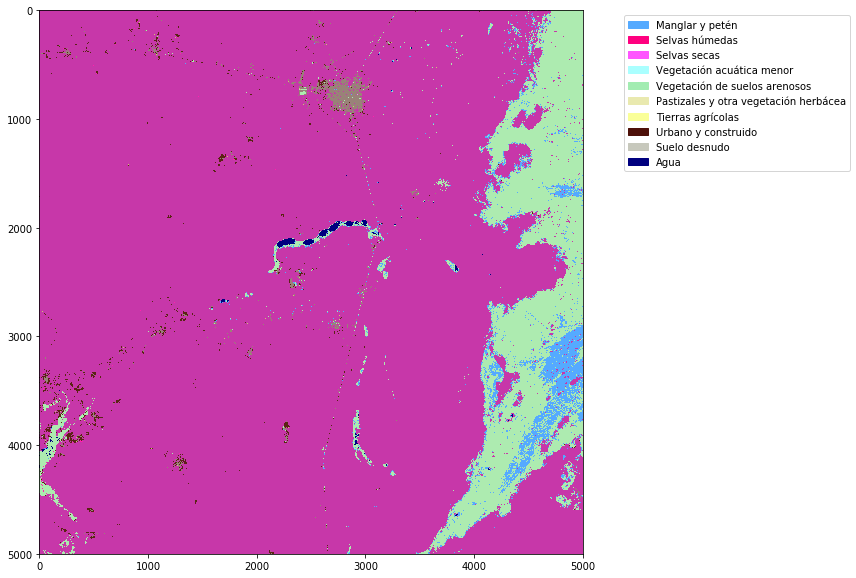

In [72]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(predicted_array, cmap = cmap_matplotlib)
ax.legend(handles=patches,
          bbox_to_anchor=(1.5, 1))
plt.show()
#plt.imshow(predicted_array, cmap = matplotlib.colors.ListedColormap(colorslist))

**Just as a reference:**

dic_values = {1: 'Bosques de aciculifolias y escuamifolias',
              2: 'Bosques latifoliados',
              3: 'Bosque húmedo de montaña',
              4: 'Manglar y petén',
              5: 'Selvas húmedas',
              6: 'Selvas secas',
              7: 'Matorral alto denso',
              8: 'Matorral mésico',
              9: 'Matorral bajo abierto',
              10: 'Vegetación acuática menor',
              11: 'Vegetación de suelos arenosos',
              12: 'Vegetación halófila',
              13: 'Pastizales y otra vegetación herbácea',
              14: 'Tierras agrícolas',
              15: 'Urbano y construido',
              16: 'Suelo desnudo',
              17: 'Agua'}

dic_colors={1:'#005100',
            2:'#007e00',
            3:'#00d900',
            4:'#55aaff',
            5:'#ff007f',
            6:'#ff55ff',
            7:'#6d4724',
            8:'#ffb265',
            9:'#aa8000',
            10:'#aaffff',
            11:'#a2ecb1',
            12:'#00aa7f',
            13:'#e9e9af',
            14:'#faff98',
            15:'#4d1009',
            16:'#c7c8bc',
            17:'#00007f'}